In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [0]:
data=mnist.load_data()

In [0]:
x_train,y_train,x_test,y_test=data[0][0],data[0][1],data[1][0],data[1][1]

In [0]:
X_train=(x_train.astype('float32')-127.5)/127.5

In [0]:
print(X_train.dtype)

float32


In [0]:
#Noise Dim
NOISE_DIM=100
adam=Adam(lr=2e-4,beta_1=0.5) 

#Generator
generator=Sequential()
generator.add(Dense(256,input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2)) 
generator.add(Dense(784,activation="tanh"))
generator.compile(loss="binary_crossentropy",optimizer=adam)
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

In [0]:
discriminator=Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation="sigmoid"))
discriminator.compile(loss="binary_crossentropy",optimizer=adam)
discriminator.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [0]:
! pip install tensorflow==1.14

In [0]:
# GAN Model
discriminator.trainable=False

gan_input  = Input(shape=(NOISE_DIM,))
fake_img   = generator(gan_input)
gan_output = discriminator(fake_img)

model=Model(gan_input,gan_output)
model.compile(loss="binary_crossentropy",optimizer=adam)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 533505    
Total params: 2,019,857
Trainable params: 1,486,352
Non-trainable params: 533,505
_________________________________________________________________


In [0]:
discriminator.compile(loss="binary_crossentropy",optimizer=adam)
discriminator.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 0
Non-trainable params: 533,505
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 D Loss 298.288780 G loss 487.564613


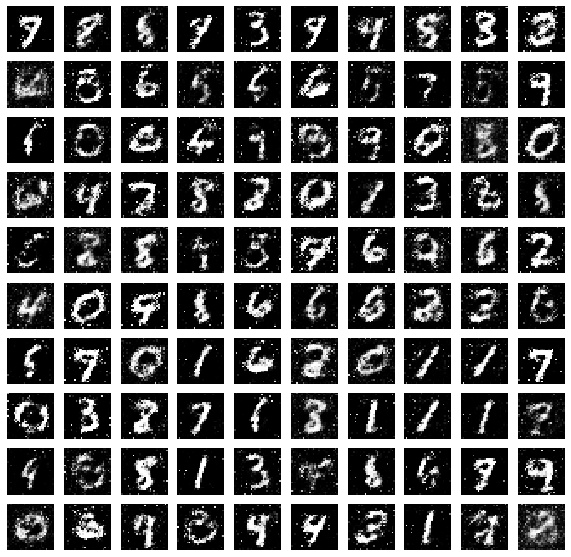

1 D Loss 296.914153 G loss 487.817250


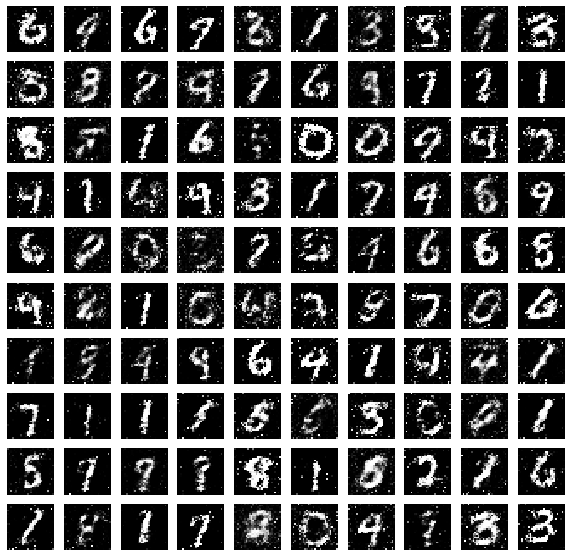

2 D Loss 297.145490 G loss 492.953121


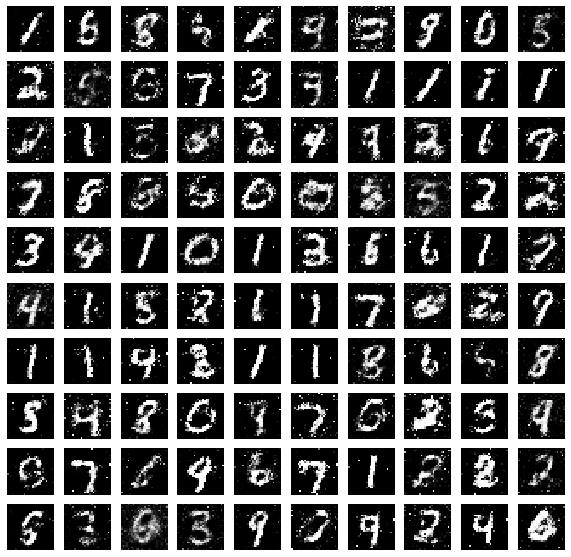

3 D Loss 299.988293 G loss 484.122563


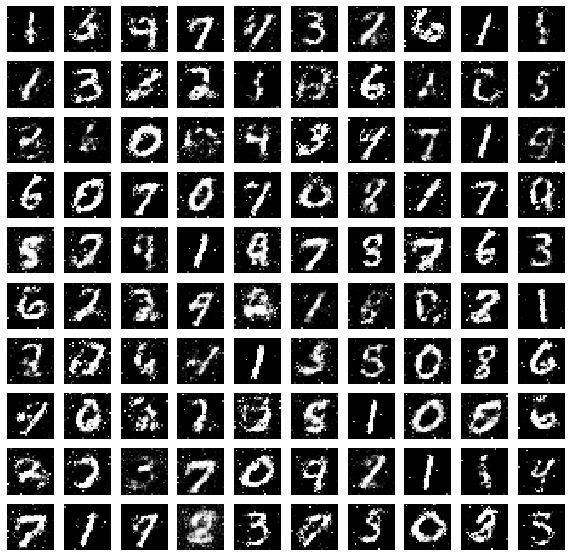

4 D Loss 304.372500 G loss 473.856739


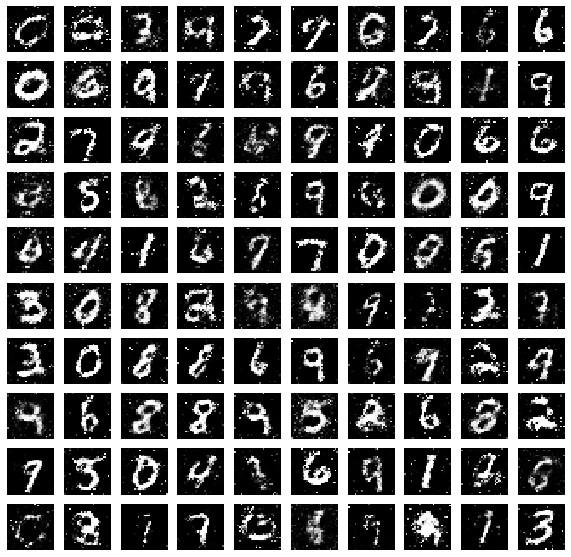

In [0]:
TOTAL_EPOCHS=5
BATCH_SIZE=256
HALF_BATCH=128

No_of_Batches=int(X_train.shape[0]/HALF_BATCH)

def show_image(epoch):
  noise=np.random.normal(0,1,size=(100,NOISE_DIM))
  fake_imgs=generator.predict(noise)*127.5+127.5
  fake_imgs=fake_imgs.reshape((100,28,28))

  plt.figure(figsize=(10,10))
  for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(fake_imgs[i],interpolation='nearest',cmap='gray')
    plt.axis('off')

  plt.show()


for epoch in range(TOTAL_EPOCHS):
  epoch_d_loss=0.0
  epoch_g_loss=0.0

  for step in range(No_of_Batches):
    #50% real images
    idx=np.random.randint(0,X_train.shape[0],HALF_BATCH)
    real_images=X_train[idx].reshape(-1,784)

    #50% fake images
    noise=np.random.normal(0,1,(HALF_BATCH,NOISE_DIM))
    fake_images=generator.predict(noise)

    # Data for the Discriminator 
    real_y=np.ones((HALF_BATCH,1))*.9
    fake_y=np.zeros((HALF_BATCH,1 ))

    d_loss_real = discriminator.train_on_batch(real_images,real_y)
    d_loss_fake = discriminator.train_on_batch(fake_images,fake_y)

    d_loss=0.5*d_loss_fake+0.5*d_loss_real
    epoch_d_loss+=d_loss


    noise=np.random.normal(0,1,size=(BATCH_SIZE,NOISE_DIM))
    real_y=np.ones((BATCH_SIZE,1))
    g_loss=model.train_on_batch(noise,real_y)
    epoch_g_loss+=  g_loss

  print("%d D Loss %f G loss %f"%((epoch,epoch_d_loss,epoch_g_loss)))

  if(epoch%1==0):
    show_image(epoch)

     

